In [24]:
%pip install implicit lightfm

     |████████████████████████████████| 1.1 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 310 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 7.1 MB/s  eta 0:00:01
     |████████████████████████████████| 155 kB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 14.5 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 6.1 MB/s  eta 0:00:01
     |████████████████████████████████| 6.8 MB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 19.2 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 2.1 kB/s  eta 0:00:01
     |████████████████████████████████| 69 kB 5.5 MB/s  eta 0:00:01
     |████████████████████████████████| 136 kB 22.0 MB/s eta 0:00:01
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3405812 sha256=43c202fea9d1fca67d3e9b19c0bd637d1927c459e4ec12731ffb9cb5436993ed
  Store

Датасет -- movie lens, так как использовался в первой домашке

In [18]:
import os
import shutil
import zipfile
import urllib.request

import implicit
import pandas as pd
import numpy as np
import scipy.sparse as sp

from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

In [3]:
movielens = fetch_movielens()

train, test = movielens['train'], movielens['test']

In [9]:
from scipy.sparse import coo_matrix

In [10]:
def to_implicit(M):
    ratings = np.copy(M.data)
    
    mask = ratings > 0
    n = np.sum(mask)
    
    return coo_matrix((np.ones(n), (M.row[mask], M.col[mask])), shape=M.shape)

In [11]:
train = to_implicit(train)
test  = to_implicit(test)

In [12]:
print(train.toarray())

[[1. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [13]:
train, test

(<943x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 90570 stored elements in COOrdinate format>,
 <943x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 9430 stored elements in COOrdinate format>)

## WARP

In [67]:
class Recommender:
    def __init__(self, user_vecs, item_vecs, user_bias=None, item_bias=None, n_rec=10):
        self.user_vecs = user_vecs
        self.item_vecs = item_vecs
        
        self.user_bias = user_bias if (user_bias is not None) else np.zeros(len(user_vecs))
        self.item_bias = item_bias if (item_bias is not None) else np.zeros(len(item_vecs))
        
        self.n_rec = n_rec
    
    def recommend(self, user_id, user_item_csr):
        seen = (user_item_csr[user_id] != 0).toarray()[0]
        similarity = np.dot(self.item_vecs, self.user_vecs[user_id]) + self.item_bias
        similarity[seen] = 0
        recommended = similarity.argsort()[::-1][:self.n_rec]
        return recommended[:,np.newaxis]
    
    def similar_items(self, item_id):
        similarity = np.dot(self.item_vecs, self.item_vecs[item_id]) / np.linalg.norm(self.item_vecs)
        similars = similarity.argsort()[::-1][:self.n_rec]
        return similars[:,np.newaxis]

In [14]:
alpha = 1e-05
epochs = 10
num_components = 64

In [32]:
warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
warp_auc = []
warp_recall = []
warp_precision = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    epoch_time = time.time() - start
    print(f"epoch {epoch} took {epoch_time}s")
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())
    warp_recall.append(recall_at_k(warp_model, test, train_interactions=train, k=5).mean())
    warp_precision.append(precision_at_k(warp_model, test, train_interactions=train, k=5).mean())

epoch 0 took 0.44964170455932617s
epoch 1 took 0.536353588104248s
epoch 2 took 0.5814609527587891s
epoch 3 took 0.6126751899719238s
epoch 4 took 0.6689064502716064s
epoch 5 took 0.6730508804321289s
epoch 6 took 0.7120556831359863s
epoch 7 took 0.7294673919677734s
epoch 8 took 0.7541708946228027s
epoch 9 took 0.7739291191101074s


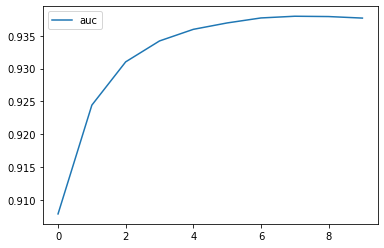

In [33]:
import matplotlib.pyplot as plt

plt.plot(np.arange(epochs), warp_auc, label='auc')
plt.legend()

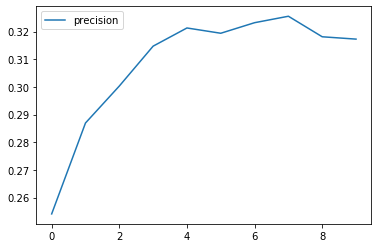

In [34]:
plt.plot(np.arange(epochs), warp_precision, label='precision')
plt.legend()

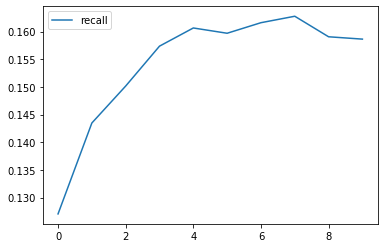

In [35]:
plt.plot(np.arange(epochs), warp_recall, label='recall')
plt.legend()

In [36]:
recall_at_k(warp_model, test, train_interactions=train, k=5).mean()

0.15864262990455993

In [37]:
precision_at_k(warp_model, test, train_interactions=train, k=5).mean()

0.3172853

## Neural recomenders

In [25]:
#!:bash
git clone https://github.com/rixwew/pytorch-fm

Cloning into 'pytorch-fm'...
Checking out files: 100% (103/103), done.


In [38]:
%pip install -r pytorch-fm/requirements.txt

     |████████████████████████████████| 876 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 17.9 MB/s eta 0:00:01
     |████████████████████████████████| 776.7 MB 1.3 kB/s  eta 0:00:011
     |████████████████████████████████| 69 kB 8.6 MB/s  eta 0:00:01
     |████████████████████████████████| 829 kB 65.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 74.2 MB/s eta 0:00:01
     |████████████████████████████████| 227 kB 76.6 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 66.0 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 59.4 MB/s eta 0:00:01
  Created wheel for lmdb: filename=lmdb-1.0.0-cp37-cp37m-linux_x86_64.whl size=222351 sha256=4669114591f58012cb79fa140c03679bdd8701dc786e038c04a3fd93fe1ad561
  Stored in directory: /root/.cache/pip/wheels/12/e2/8d/261e2b6143cc3e0e690ccc065

In [46]:
movielens = fetch_movielens()
len(movielens['train'].data), len(movielens['test'].data)

(90570, 9430)

In [51]:
ratings = pd.read_csv('ml-1m/ratings.dat', delimiter='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')
ratings.head(5)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [56]:
movie_info = pd.read_csv('ml-1m/movies.dat', delimiter='::', header=None, names=['movie_id', 'name', 'category'], engine='python')
movie_info.head(5)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [64]:
user_info  = pd.read_csv('ml-1m/users.dat', delimiter='::', header=None, names=['user_id', 'gender', 'age_group', 'occupation', 'zip_code'], engine='python')
user_info  = user_info.drop(['zip_code'], axis=1)
user_info.head(5)

,user_id,gender,age_group,occupation
0,1,F,1,10
1,2,M,56,16
2,3,M,25,15
3,4,M,45,7
4,5,M,25,20


In [82]:
#!L
import torch
import torch.nn as nn
import torch.nn.functional as F

In [111]:
#!L
N_USERS  = max(ratings['user_id']) + 1
N_MOVIES = max(ratings['movie_id']) + 1

In [110]:
#!L
device = torch.device('cuda')
device

device(type='cuda')

In [131]:
#!L
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, embed_dims, dropout=0.1):
        super().__init__()
        layers = []
        for embed_dim in embed_dims:
            layers.extend([
                nn.Linear(input_dim, embed_dim),
                nn.ReLU(),
                nn.Dropout(p=dropout),
            ])
            input_dim = embed_dim
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [154]:
#!L
def Embedding(n, dim):
    scale = 1. / np.sqrt(dim)
    embedding = nn.Embedding(n, dim)
    embedding = embedding.weight.data.uniform_(0, scale)
    return embedding
    
class NCF(nn.Module):
    def __init__(self, n_users, n_items, dim=4, hidden_size=4):
        super().__init__()
        self.dim = dim
        self.mf_user_emb = Embedding(n_users, dim).cuda()
        self.nn_user_emb = Embedding(n_users, dim).cuda()
        
        self.mf_item_emb = Embedding(n_items, dim).cuda()
        self.nn_item_emb = Embedding(n_items, dim).cuda()
        
        self.mlp = MultiLayerPerceptron(dim * 2, [hidden_size, hidden_size])
        self.linear = nn.Linear(hidden_size + dim, 1)
    
    def forward(self, user_idx, item_idx):
        print(user_idx, item_idx)
        print(self.nn_user_emb.data)
        print(self.nn_user_emb[user_idx])
        print(self.nn_item_emb[item_idx])
        gft_out = self.mf_user_emb[user_idx] * self.mf_item_emb[item_idx]
        
        x_nn = torch.cat((self.nn_user_emb[user_idx], self.nn_item_emb[item_idx]), dim=1)
        print(x_nn)
        mlp_out = self.mlp(x_nn)
        
        x = torch.cat((mlp_out, gft_out), dim=1)
        x = self.linear(x)
        return torch.sigmoid(x)

In [155]:
#!L
model = NCF(N_USERS, N_MOVIES).to(device)
model

NCF(
  (mlp): MultiLayerPerceptron(
    (layers): Sequential(
      (0): Linear(in_features=8, out_features=4, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=4, out_features=4, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
    )
  )
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

In [156]:
#!L
model.forward(
    torch.LongTensor([1,2]).to(device), 
    torch.LongTensor([3, 4]).to(device)
)

tensor([1, 2], device='cuda:0') tensor([3, 4], device='cuda:0')
tensor([[0.0443, 0.0726, 0.3278, 0.0916],
        [0.4687, 0.2431, 0.3986, 0.4161],
        [0.3055, 0.0497, 0.1222, 0.1347],
        ...,
        [0.3872, 0.0391, 0.0858, 0.2688],
        [0.2385, 0.3942, 0.1204, 0.1855],
        [0.3107, 0.1751, 0.2701, 0.3337]], device='cuda:0')
tensor([[0.4687, 0.2431, 0.3986, 0.4161],
        [0.3055, 0.0497, 0.1222, 0.1347]], device='cuda:0')
tensor([[0.3424, 0.3365, 0.4821, 0.1480],
        [0.1847, 0.1794, 0.2498, 0.1398]], device='cuda:0')
tensor([[0.4687, 0.2431, 0.3986, 0.4161, 0.3424, 0.3365, 0.4821, 0.1480],
        [0.3055, 0.0497, 0.1222, 0.1347, 0.1847, 0.1794, 0.2498, 0.1398]],
       device='cuda:0')


tensor([[0.5270],
        [0.5005]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
#!L
